In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os

import pandas as pd
import numpy as np

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from config import PROCESSED_FOLDER_PATH
from chesswinnerprediction.baseline.utils import get_x_and_y, get_class_weights, estimate_baseline_model

In [3]:
data_path = os.path.join(PROCESSED_FOLDER_PATH, "lichess_db_standard_rated_2017-05.csv")
original_df = pd.read_csv(data_path)

In [4]:
BASELINE_COLUMNS = [
    "Result",  
    "EloDiff",
    "WhiteElo", 
    "BlackElo", 
    "Event",
    "BaseTime", 
    "IncrementTime", 
    "ZeroIncrementTime"
]

In [5]:
df = original_df[BASELINE_COLUMNS].copy()

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 952632 entries, 0 to 952631
Data columns (total 8 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Result             952632 non-null  object
 1   EloDiff            952632 non-null  int64 
 2   WhiteElo           952632 non-null  int64 
 3   BlackElo           952632 non-null  int64 
 4   Event              952632 non-null  object
 5   BaseTime           952632 non-null  int64 
 6   IncrementTime      952632 non-null  int64 
 7   ZeroIncrementTime  952632 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 58.1+ MB


In [7]:
df.head()

,Result,EloDiff,WhiteElo,BlackElo,Event,BaseTime,IncrementTime,ZeroIncrementTime
0,0-1,334,1756,1422,Rated Classical game,900,0,1
1,1-0,-205,2064,2269,Rated Bullet tournament,60,0,1
2,1-0,-11,1543,1554,Rated Blitz game,300,3,0
3,1-0,-218,1736,1954,Rated Blitz game,180,2,0
4,1-0,-45,1343,1388,Rated Blitz game,180,2,0


In [8]:
df = pd.get_dummies(df, columns=["Event"], dtype=np.int8, prefix="", prefix_sep="")

columns_to_scale = ["WhiteElo", "BlackElo", "EloDiff", "BaseTime", "IncrementTime"]
df[columns_to_scale] = StandardScaler().fit_transform(df[columns_to_scale])

In [9]:
X, y = get_x_and_y(df, predict_draws=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

class_weight = get_class_weights(y_train)

## Apply the Decision Tree Classifier

In [10]:
tree_clf = DecisionTreeClassifier(max_depth=10, class_weight=class_weight)
tree_clf.fit(X_train, y_train)

DecisionTreeClassifier(class_weight={'0-1': np.float64(0.6974281884086265),
                                     '1-0': np.float64(0.6717216113772295),
                                     '1/2-1/2': np.float64(12.911779765669708)},
                       max_depth=10)

log loss on test data: 1.0577671515686737

						Classification Report 
              precision    recall  f1-score   support

         0-1       0.58      0.45      0.51     45380
         1-0       0.62      0.39      0.48     47435
     1/2-1/2       0.04      0.52      0.08      2449

    accuracy                           0.42     95264
   macro avg       0.42      0.45      0.36     95264
weighted avg       0.59      0.42      0.48     95264



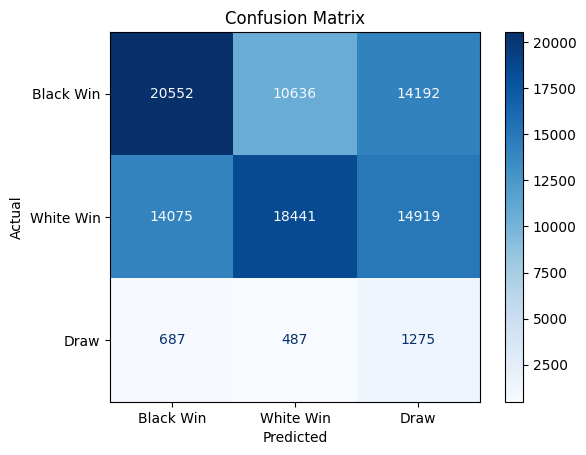

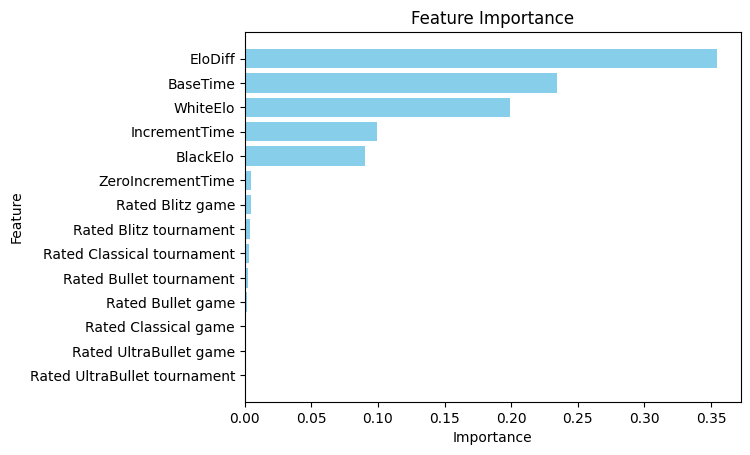

In [11]:
estimate_baseline_model(tree_clf, X_test, y_test, tree_clf.feature_importances_)

## Apply the Random Forest Classifier

In [12]:
forest_clf = RandomForestClassifier(class_weight=class_weight, n_estimators=40, max_depth=13, n_jobs=4)
forest_clf.fit(X_train, y_train)

RandomForestClassifier(class_weight={'0-1': np.float64(0.6974281884086265),
                                     '1-0': np.float64(0.6717216113772295),
                                     '1/2-1/2': np.float64(12.911779765669708)},
                       max_depth=13, n_estimators=40, n_jobs=4)

log loss on test data: 0.9914003602607262

						Classification Report 
              precision    recall  f1-score   support

         0-1       0.59      0.46      0.52     45380
         1-0       0.62      0.45      0.52     47435
     1/2-1/2       0.05      0.47      0.08      2449

    accuracy                           0.46     95264
   macro avg       0.42      0.46      0.38     95264
weighted avg       0.59      0.46      0.51     95264



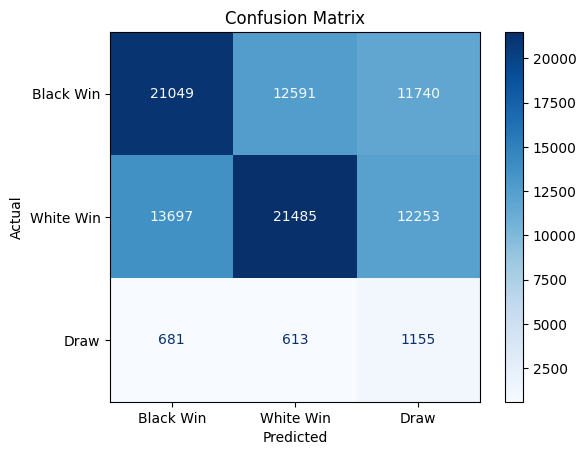

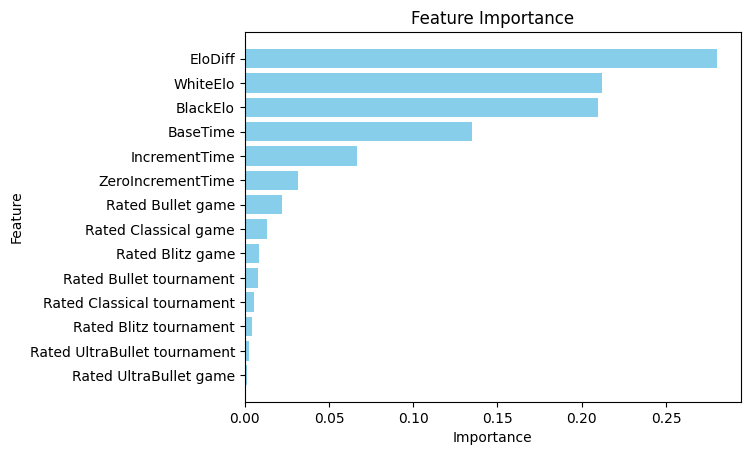

In [13]:
estimate_baseline_model(forest_clf, X_test, y_test, forest_clf.feature_importances_)